---
title: Exploratory Analysis & Modeling Pre-Deployment
author: ''
date: '2020-02-15'
slug: pre-deployment
categories: []
tags: []
---

This post is the pre-cursor to my next post on deploying ML models as a REST API via Flask & Heroku. Here I do some exploratory analysis and compare different models. The dataset contains attributes about users and whether or not they converted in a marketing campaign. 

In [1]:
import pandas as pd
from bokeh.io import show, output_file
from bokeh.plotting import figure

marketing=pd.read_csv("data/marketing_new.csv",index_col=0)

In [2]:
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained,DoW,channel_code,is_correct_lang
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaN,House Ads,True,0.0,1.0,Yes


I want to look at how conversion rate differs by various groups in the data. I will write a function to calculate the conversion rate by any arbitrary grouping so that I can look at many different slices quickly. 

1. The function first filters for converted users & counts the number of by group as num_conv (a series object).

2. Then it counts the total number of users in the group as total (also a series)

3. It returns a series object with a conversion rate by group


In [3]:
def get_conversion_rate(df, grouping):
    num_conv = df[df['converted'] == True]\
                       .groupby(grouping)['user_id'].nunique()

    total = df.groupby(grouping)['user_id'].nunique()   
    
    conversion_rate = num_conv/total
    
    conversion_rate = conversion_rate.fillna(0)
    
    return conversion_rate


I can then call it for many different groupings...

In [4]:
#by age group 
get_conversion_rate(marketing,['age_group'])

age_group
0-18 years     0.160596
19-24 years    0.234124
24-30 years    0.188525
30-36 years    0.074599
36-45 years    0.071834
45-55 years    0.072779
55+ years      0.079511
Name: user_id, dtype: float64

In [5]:
#multiple groupings
get_conversion_rate(marketing,['date_served','marketing_channel']).head(15)

date_served  marketing_channel
2018-01-01   Email                1.000000
             Facebook             0.117647
             House Ads            0.084656
             Instagram            0.106667
             Push                 0.083333
2018-01-02   Email                1.000000
             Facebook             0.098361
             House Ads            0.077982
             Instagram            0.129032
             Push                 0.055556
2018-01-03   Email                0.000000
             Facebook             0.080645
             House Ads            0.088542
             Instagram            0.171875
             Push                 0.083333
Name: user_id, dtype: float64

When I group by two columns, I see that the conversion for the email channel is 100% on some days but 0% on others.This is strange, so it would be useful to know what the actual #'s were for converted users and total users. It might be the case that no emails were sent on 1-03. 
So what if my function instead returns a dataframe that also has a column with # converted & # total ? 

I will again create the two series objects but will this time merge them to keep both of their values and assign a new column for conversion rate. I need to use an outer join and fill NA to 0 to keep all rows (otherwise Email on 1-03 would be dropped since no conversions on this date). 

In [6]:
def get_conversion_rate(df,grouping):
    num_convs=df[df['converted'] == True]\
                       .groupby(grouping)['user_id'].nunique().rename('num_converted')

    total = df.groupby(grouping)['user_id'].nunique().rename('num_total')

    conv_rate=pd.merge(num_convs,total,left_index=True,right_index=True,how='outer')\
        .assign(not_conv=lambda x: x['num_total']-x['num_converted'],conv_rate=lambda x: x['num_converted']/x['num_total'])\
        .fillna(0)
    return conv_rate.reset_index()

get_conversion_rate(marketing,['marketing_channel'])





,marketing_channel,num_converted,num_total,not_conv,conv_rate
0,Email,187,553,366,0.338156
1,Facebook,221,1758,1537,0.125711
2,House Ads,298,3968,3670,0.075101
3,Instagram,232,1740,1508,0.133333
4,Push,77,972,895,0.079218


### Bokeh Visualizations



In [8]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.palettes import RdBu3,Spectral5
from bokeh.transform import factor_cmap

output_notebook()

def make_plot(df,col_name):
    
    grouped=get_conversion_rate(df,[col_name])
    
    source = ColumnDataSource(grouped)
    group=source.data[col_name].tolist()

    group_cmap = factor_cmap(col_name, palette=Spectral5, factors=sorted(grouped[col_name].unique()))

    title="Conversion by: " + col_name
    p = figure(plot_height=350, x_range=group, title=title)

    p.vbar(x=col_name, top='num_converted', width=1,
       line_color=group_cmap, fill_color=group_cmap,source=source)
        
    p.y_range.start = 0
    p.xgrid.grid_line_color = None
    p.xaxis.axis_label =col_name
    p.xaxis.major_label_orientation = 1.2
    p.outline_line_color = None
    
    return p

show(make_plot(marketing,'marketing_channel'))

Loading BokehJS ...

From this, it is more clear that the email channel is so small that the conversion rate is not meaningful. 

### Modeling
Now I will build some simple models to predict conversion from a subset of features

In [12]:
from sklearn.model_selection import train_test_split
X = marketing[['marketing_channel','subscribing_channel','age_group']]
y = marketing['converted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Index(['marketing_channel', 'subscribing_channel', 'age_group'], dtype='object')

Since I am only using categorical features, I will build a preprocessing pipeline to fill missing values with 'missing'
and one hot encode category types
I will compare logistic regression and a decision tree classifier. 

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier


categorical_features=X_train.select_dtypes('object').columns

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])


def make_preds(classifier):
    pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    model=pipe.fit(X_train, y_train)
    print(classifier)
    print("model score: ",pipe.score(X_test, y_test))
    y_pred = pipe.predict(X_test)
    return model,y_pred

lg_model,lg_pred=make_preds(LogisticRegression(solver='lbfgs'))
dt_model,dt_pred=make_preds(DecisionTreeClassifier(max_depth=4))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
model score:  0.9646414342629482
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
model score:  0.9606573705179283


In [15]:
feature_names = dt_model.named_steps['preprocessor'].transformers_[0][1]\
    .named_steps['onehot'].get_feature_names(categorical_features)

feature_names


array(['marketing_channel_Email', 'marketing_channel_Facebook',
       'marketing_channel_House Ads', 'marketing_channel_Instagram',
       'marketing_channel_Push', 'marketing_channel_missing',
       'subscribing_channel_Email', 'subscribing_channel_Facebook',
       'subscribing_channel_House Ads', 'subscribing_channel_Instagram',
       'subscribing_channel_Push', 'subscribing_channel_missing',
       'age_group_0-18 years', 'age_group_19-24 years',
       'age_group_24-30 years', 'age_group_30-36 years',
       'age_group_36-45 years', 'age_group_45-55 years',
       'age_group_55+ years'], dtype=object)

C:\Users\mikay\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


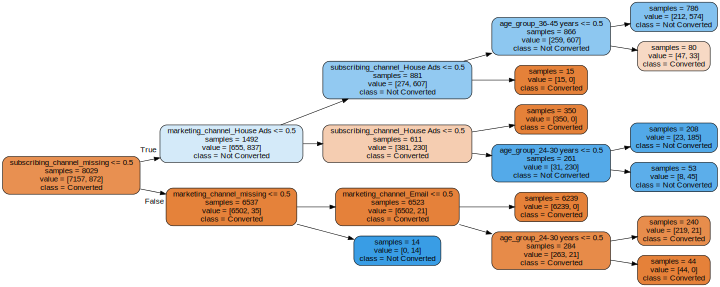

In [16]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import graphviz
import pydotplus
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\mikay\Anaconda3\pkgs\graphviz-2.38-hfd603c8_2\Library\bin\graphviz'


dot_data = export_graphviz(dt_model['classifier'], out_file=None, feature_names = feature_names,
                class_names = ['Converted','Not Converted'],
                rounded = True, proportion = False, precision = 1, rotate=True,impurity=False,filled=True)

pdot = pydotplus.graph_from_dot_data(dot_data)
pdot.set_graph_defaults(size = "\"10,7\"",fontsize='14')
graph = graphviz.Source(pdot.to_string())
graph


In [18]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive

def plot_tree(crit, split, depth, min_split, min_leaf):
    classifier = DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)

    pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
    model=pipe.fit(X_train, y_train)
    
    feature_names = dt_model.named_steps['preprocessor'].transformers_[0][1]\
        .named_steps['onehot'].get_feature_names(categorical_features)
    
    graph = Source(export_graphviz(model['classifier']
      , out_file=None
      , feature_names=feature_names
      , class_names=['Converted','Not Converted']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return model['classifier']

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[3,4]
   , min_split=(0.1,1)
   , min_leaf=(1,2))


display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

##### Returns dataframe with one colume for y_test (actual) and one column for y_pred (predicted value)

In [19]:
def get_preds_df(y_pred):
    y_test.rename('y_actual',inplace=True)
    preds_df = pd.DataFrame(data = y_pred, columns = ['y_pred'], index = X_test.index.copy())
    return X_test.merge(preds_df,how='inner',left_index = True, right_index = True).merge(y_test,left_index = True, right_index = True)

dt_preds_df=get_preds_df(dt_pred)
dt_preds_df.head()

,marketing_channel,subscribing_channel,age_group,y_pred,y_actual
1166,Facebook,Instagram,45-55 years,True,False
502,Email,Email,0-18 years,True,True
9280,House Ads,NaN,24-30 years,False,False
8520,Push,NaN,45-55 years,False,False
7071,House Ads,NaN,36-45 years,False,False


In [20]:
def pred_types(preds_df):
    tp=preds_df[(preds_df.y_actual==True) & (preds_df.y_pred==True)]
    tn=preds_df[(preds_df.y_actual==False) & (preds_df.y_pred==False)]
    fp=preds_df[(preds_df.y_actual==False) & (preds_df.y_pred==True)]
    fn=preds_df[(preds_df.y_actual==True) & (preds_df.y_pred==False)]
    return tp,tn,fp,fn

tp,tn,fp,fn=pred_types(dt_preds_df)

fp.head()

,marketing_channel,subscribing_channel,age_group,y_pred,y_actual
1166,Facebook,Instagram,45-55 years,True,False
1199,Push,Instagram,0-18 years,True,False
1356,Instagram,Instagram,45-55 years,True,False
1620,Facebook,Facebook,45-55 years,True,False
1142,Facebook,Facebook,30-36 years,True,False


In [22]:
from sklearn.metrics import confusion_matrix

def make_model(feat):
    X = marketing[[feat]]
    y = marketing['converted']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    categorical_features = X_train.select_dtypes(include=['object']).columns

    categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[('preprocessor', preprocessor),('classifier', DecisionTreeClassifier(max_depth=4))])
    model=pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print("model score: ",pipe.score(X_test, y_test))
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

inter=interactive(make_model 
   , feat = ['marketing_channel','subscribing_channel','variant','age_group'])

display(inter)

interactive(children=(Dropdown(description='feat', options=('marketing_channel', 'subscribing_channel', 'varia…

#### Load Model & Predict on JSON Data
- Testing to prepare for deploying as API with Flask

In [23]:
import pickle
import pandas as pd
import numpy as np

loaded_model=pickle.load(open("model.pkl","rb"))
json={"marketing_channel": "House Ads", "subscribing_channel": "Instagram", "age_group": "55+ years"}  
query = pd.DataFrame([json])
print(query)

def pred(query):
    p=loaded_model.predict_proba(query)
    
    p=tuple(p[0,])
    if p[0]>.5:
        print(str(p[0]*100)+'%')
        return False
    else:
        print(p[1]*100)
        return True
    

pred(query)






   age_group marketing_channel subscribing_channel
0  55+ years         House Ads           Instagram
100.0%


False